In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    read_csv_from_web,
    implementPairDecayLimit,
    implementPairProductionLimit
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution
from Higgs.tools.LimitValidation import validateChannelLimit, validateChannelWidthLimit

# CMS 13TeV LHC

## `H > hSM hSM > bb + bb/tautau/WW/ZZ/gamgam` [1811.09689](https://arxiv.org/abs/1811.09689)
The quoted limit does not include the BRs of daughter higgses, but assumes hSM. We multiply with the combined reference BR into all considered channels and then include the BRs in the process definition.

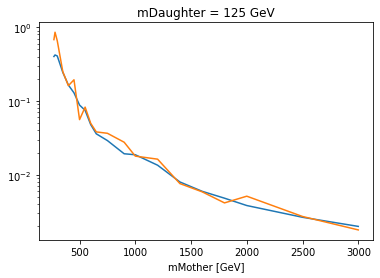

Looks good. Saving this to H_LHC13_CMS_36.json


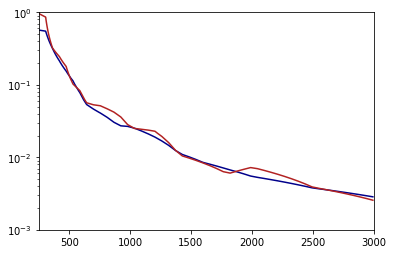

In [4]:
dfExp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1704939/Figure%203/1/csv",
    comment="#",
    skiprows=60,
    names=["m", "exp", "unc+", "unc-"],
)

df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1704939/Figure%203/1/csv",
    comment="#",
    skiprows=10,
    skipfooter=82 - 31,
    engine="python",
    names=["mMother", "obs"],
)
assert np.allclose(df.mMother, dfExp.m)
df["exp"] = dfExp.exp
df.exp *= 1e-3  # fb to pb
df.obs *= 1e-3  # fb to pb
df["mDaughter1"] = 125
decModes = ["bb", "tautau", "WW", "ZZ", "gamgam"]
ref = HP.SMHiggs(125)
refBr = np.sum([ref.br(d) for d in decModes]) * ref.br("bb")

df.exp *= refBr
df.obs *= refBr
limitFile = implementPairDecayLimit(
    "1811.09689",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": decModes,
    },
    "Fig. 5 (upper)",
    df,
    massResolution={
        "firstDaughter": {"absolute": 30, "relative": 0},  # bb resolution is bad
        "secondDaughter": {
            "absolute": 10,
            "relative": 0,
        },  # the other decay includes ZZ and gamgam with better res
        "mother": resolution.bb["highMass"],
    },
    constraints={
        "secondDaughter": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setMass(125)
HP.effectiveCouplingInput(h1, HP.smLikeEffCouplings)
hm = np.linspace(250, 3000)
r = np.linspace(1e-3, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## non-res `pp > hSM hSM > bb/tautau/WW/ZZ/gamgam` [1811.09689](https://arxiv.org/abs/1811.09689)
The quoted limit does not include the BRs of daughter higgses, but assumes hSM. We multiply with the combined reference BR into all considered channels and then include the BRs in the process definition.

In [8]:
df = pd.DataFrame({"m": [125], "obs": 22.2, "exp": 12.8})
refCxn = 33.53e-3
decs = ["bb", "tautau", "gamgam", "WW", "ZZ"]
sm = HP.SMHiggs(125)
df.obs *= refCxn * sum((sm.br(d) for d in decs)) * sm.br("bb")
df.exp *= refCxn * sum((sm.br(d) for d in decs)) * sm.br("bb")

limitFile = implementPairProductionLimit(
    "1811.09689",
    {"firstDecay": ["bb"], "secondDecay": decs},
    "Fig. 1",
    df,
    massResolution={
        "firstParticle": {"absolute": 30, "relative": 0.0},  # bb resolution is bad
        "secondParticle": {
            "absolute": 10,
            "relative": 0.0,
        },  # guess +-5 because gamgam is in there
    },
    idSuffix=1,
    constraints={
        "secondParticle": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["none", d] for d in decModes]},
            }
        ],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setMass(125)
HP.effectiveCouplingInput(h2, HP.smLikeEffCouplings)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1 / sum((sm.br(d) for d in decs)))
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])



Looks good. Saving this to nonres_LHC13_CMS_36.json
[<Higgs.bounds.AppliedLimit limitId: 1811096891, obsRatio: 2.552, expRatio: 4.426, for: ["h1", "h2", "+", "h2"]>]


## `hSM > a a > bb + mumu/tautau` [2402.13358](https://arxiv.org/abs/2402.13358)

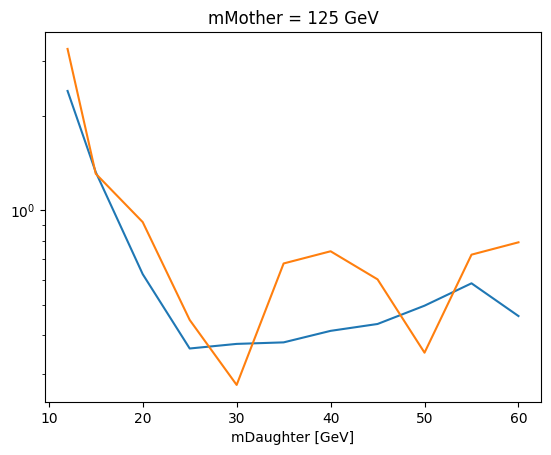

Looks good. Saving this to H_LHC13_CMS_138.json


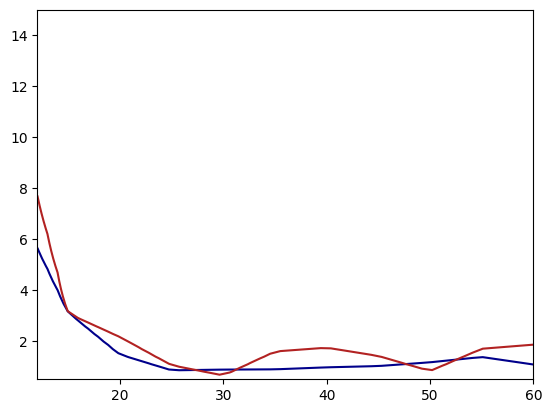

In [3]:

df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins2760544/Figure%2012/1/csv",
    comment="#",
    skiprows=10,
    skipfooter=55 - 22,
    engine="python",
    names=["mDaughter1", "obs"],
)
dfexp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins2760544/Figure%2012/1/csv",
    comment="#",
    skiprows=26,
    skipfooter=55 - 38,
    engine="python",
    names=["mDaughter1", "exp", "-1d", "+1d"],
)
df['exp']=dfexp.exp
del dfexp
df["mMother"] = 125


ref = HP.SMHiggs(125)
refCxn = ref.cxn("LHC13", 'H') 
df.obs *= refCxn*1e-2
df.exp *= refCxn*1e-2


limitFile = implementPairDecayLimit(
    2760544,
    {
        "production": ['H'],
        "firstDecay": ["bb"], 
        "secondDecay": ["mumu", "tautau"]},
    "Fig. 12",
    df,
    massResolution={
        "firstDaughter": resolution.bb["medMass"],
        "secondDaughter": {
            "absolute": 5,
            "relative": 0.0,
        },  
        "mother": {
            "absolute": 12.5,
            "relative": 0.25,}
    }, 
    # constraints={
    #         'firstDaughter':[{'CPValue':'odd'},],
    #         'secondDaughter':[{'CPValue':'odd'},],
    # },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh", "even"))
a1 = pred.addParticle(HP.NeutralScalar("a1", "odd"))
a2 = pred.addParticle(HP.NeutralScalar("a2", "odd"))
hh.setDecayWidth("a1", "a2", 1.0)
a1.setDecayWidth("bb", 1.0)
a2.setDecayWidth("tautau", 0.5)
a2.setDecayWidth("mumu", 0.5)
hh.setMass(125)
hm = np.linspace(12.0, 60.0)
r = np.linspace(0.5, 15)

def testAgainstLimit(mass, rate):
    a1.setMass(mass)
    a2.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate * refCxn * 1e-2)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0,0)
    return app[0].expRatio(), app[0].obsRatio()

test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)

def debug(npda):
    lst = []
    for li in npda:
        lst.append(list(li))
    return(lst)

expR = debug(expR)
obsR = debug(obsR)


fig, ax = plt.subplots(1,1)
expCc = ax.contour(XX, YY, expR, levels=[1.0,], colors=["darkblue"])
obsCc = ax.contour(XX, YY, obsR, levels=[1.0,], colors=["firebrick"])
# expCc.collections[0].set_label("expRatio = 1")
# obsCc.collections[0].set_label("obsRatio = 1")